Tutorial for Feature  Matching <br> Resource: https://huggingface.co/learn/computer-vision-course/en/unit1/feature-extraction/feature-matching

In [3]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

(-0.5, 4607.5, 2591.5, -0.5)

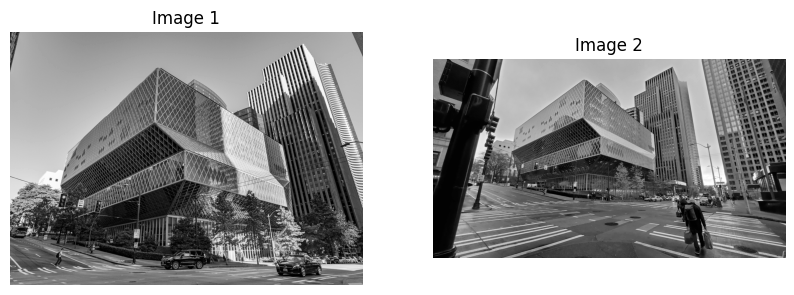

In [4]:
# Read the input images


# Get the image path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)

img1_path = os.path.join(project_root, "src", "data", "feature_matching", "seattle_central_library.jpg")
img2_path = os.path.join(project_root, "src", "data", "feature_matching", "seattle_central_library_2.jpg")

# Read the images
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the images
axes[0].imshow(img1, cmap="gray")
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(img2, cmap="gray")
axes[1].set_title("Image 2")
axes[1].axis("off")



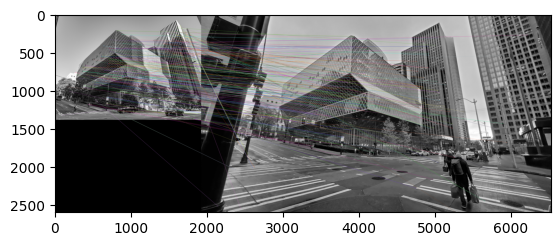

In [6]:
# Feature Matching using Brute Force Matching (BFMatcher) + SIFT Features

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract sift keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Initialize Brute Force Matcher
bf = cv2.BFMatcher()

# Apply K Nearest Nearest Neighbor to find matches, with No. of nearest nbrs : k = 2
matches = bf.knnMatch(des1, des2, k=2)

# Apply Ratio test to threshold the best matches
good_matches = []
THRESHOLD_RATIO_TEST = 0.75
for best_match, second_best_match in matches:
    if best_match.distance < THRESHOLD_RATIO_TEST * second_best_match.distance:
        good_matches.append([best_match])
        
# Draw the matches
img3 = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the matches
plt.figure()
plt.imshow(img3)

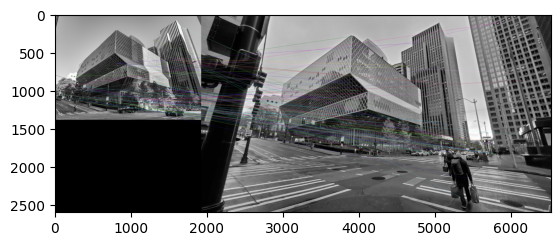

In [9]:
# Feature Matching with ORB Descriptors + Brute Force Matching + Hamming Distance

# ORB: Oriented FAST and Rotated BRIEF
# - efficient and fast descriptor, good for real time applications
# - scale and rotation invariant
# - binary descriptor , good for mobile and embedded systems
# - used in object detection, tracking, image stitching, SLAM
# - How it works?
#     1. Apply FAST (Features from Accelerated Segment Test) to find keypoints in image
#     2. Compute keypoints' orientation using intensity centroid method
#     3. Apply BRIEF (Binary Robust Independent Elementary Features) to generate descriptor
# - 256 bit binary descriptor

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort the matches in the order of their distance
matches_sorted = sorted(matches, key=lambda x: x.distance)

# Draw first n matches
n = 100
img_orb_bf = cv2.drawMatches(img1, kp1, img2, kp2, matches[:n], None,\
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image
plt.figure()
plt.imshow(img_orb_bf)


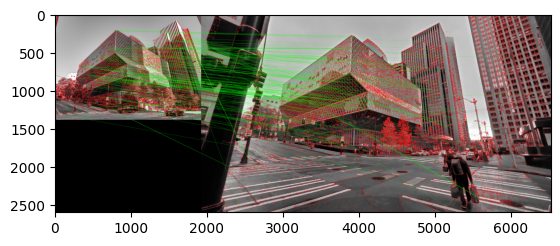

In [6]:
# Feature Matching using FLANN: Fast Approx. Nearest Neighbors with Automatic Algorithm Configuration


#FLANN:
# speeds up search by approximating nearest neighbors
#  Suitable for large datasets + high dimensional descriptors like SIFT or SURF
# How it works?
#  - Organizes feature descriptors using KD Trees - this builds an index.
#  - Finds close matches (not exact matches) using optimized search algorithms
#  - Chooses best matching method based on datasets.


# Find SIFT Keypoints and Descriptors
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Parameters for Feature matching using SIFT Descriptors
FLANN_INDEX_KDTREE = 1
NUM_KDTREES_FOR_SEARCHING_NN = 5
MAX_NUM_LEAFS = 50
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=NUM_KDTREES_FOR_SEARCHING_NN)
search_params = dict(checks=MAX_NUM_LEAFS)

# Feature Matching using FLANN
flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Perform ratio test to determine good matches
matches_mask = [[0, 0] for i in range(len(matches))]

THRESHOLD_RATIO_TEST = 0.7
for i, (first_match, second_match) in enumerate(matches):
    if first_match.distance < THRESHOLD_RATIO_TEST * second_match.distance:
        matches_mask[i] = [1, 0]
        
# Visualize the matches
draw_params = dict(
    matchColor = (0, 255, 0),
    singlePointColor = (255, 0, 0),
    matchesMask = matches_mask,
    flags=cv2.DrawMatchesFlags_DEFAULT
)

img_flann = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

# Display the image
plt.figure()
plt.imshow(img_flann)


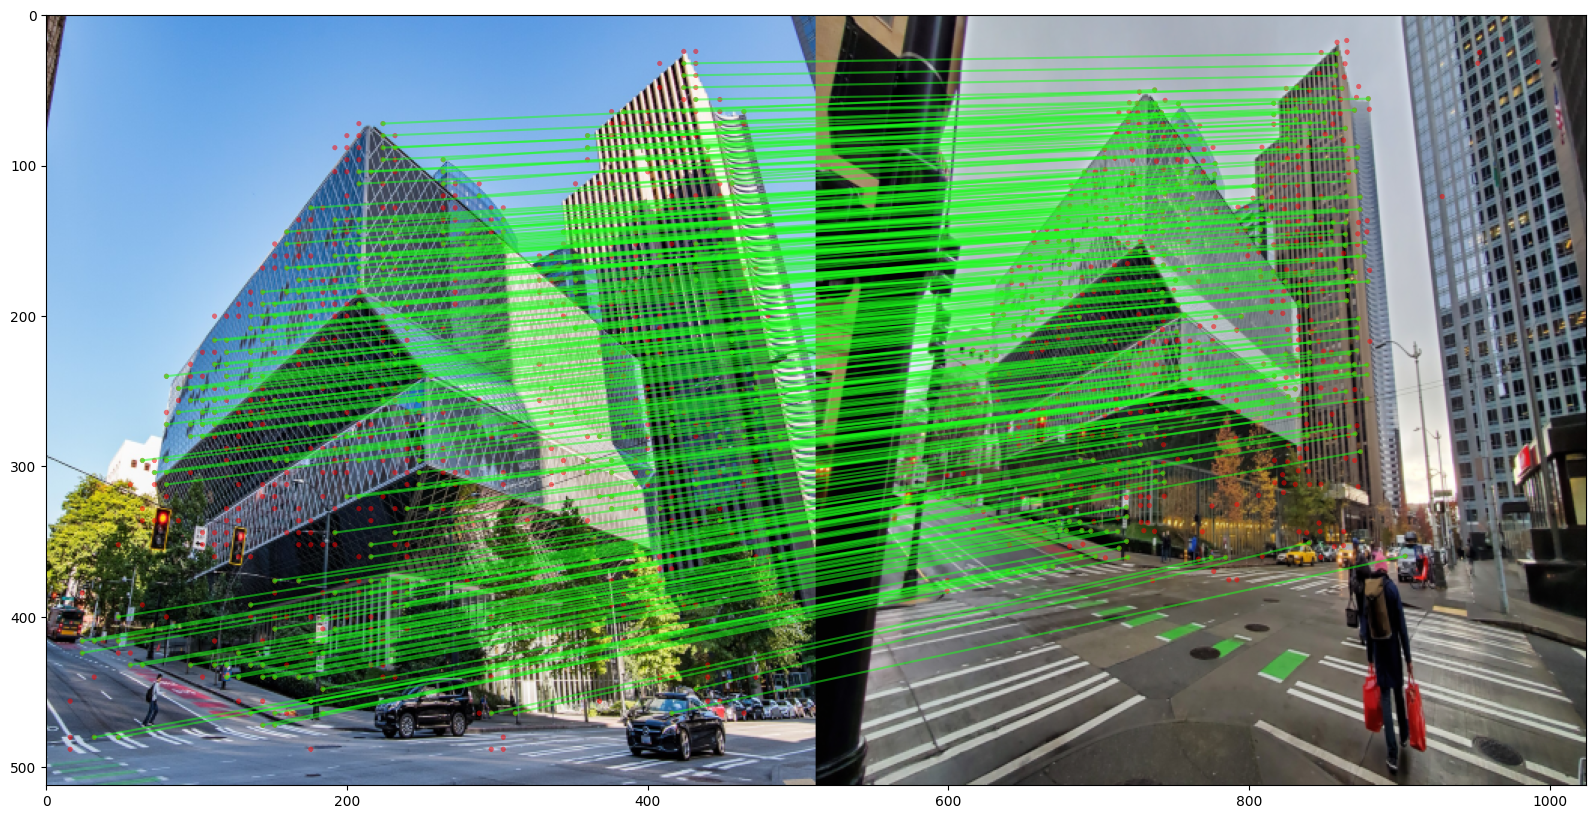

In [ ]:
# Local Feature Matching with Transformers (LoFTR)

#LoFTR:
# Uses specific key points (ex: landmarks or structures) for matching instead of pixel by pixel matching
# Rotation and Scale invariant, lighting, angle or perspective invariant
# Assigns a similarity score during matching; higher score implies better match
# Application - image stitching

# !!!PreReq: Install Kornia Library
# pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade


# Import Libraries
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches
from kornia.feature import LoFTR

# ----Load and resize the images-----

# Get the image path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)

img1_path = os.path.join(project_root, "src", "data", "feature_matching", "seattle_central_library.jpg")
img2_path = os.path.join(project_root, "src", "data", "feature_matching", "seattle_central_library_2.jpg")

# Read the images
img1 = K.io.load_image(img1_path, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(img2_path, K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

#------------ Perform LoFTR matching------------

# Specify if the image is indoor or outdoor image
matcher = LoFTR(pretrained="outdoor")

with torch.inference_mode():
    correspondences = matcher(input_dict)

# Remove Outliers using RANSAC

matched_keypoints_0 = correspondences["keypoints0"].cpu().numpy()
matched_keypoints_1 = correspondences["keypoints1"].cpu().numpy()


# MAGSAC: Maximum A Posteriori Sample Consensus
#   - Advanced variant of RANSAC (Random Sample Consensus)
#   - More robust against outliers, better accuracy, no need to set a threshold manually.
# RANSAC Reprojection threshold : max distance in pixels between a point and its epipolar line for it to be considered an inlier
# Confidence: probability that estimated fundamental matrix is correct
# Maximum Iterations: max. no. of iterations for Robust Estimation Algorithm
RANSAC_PROJECTION_THRESHHOLD = 0.5
CONFIDENCE = 0.999
MAX_ITERATIONS = 100000

#F: Fundamental Matrix
# inliers has 1 where keypoint is inlier, 0 otherwise.
F, inliers = cv2.findFundamentalMat(
    matched_keypoints_0,
    matched_keypoints_1,
    cv2.USAC_MAGSAC,
    RANSAC_PROJECTION_THRESHHOLD,
    CONFIDENCE,
    MAX_ITERATIONS
)

inliers = inliers > 0

#------------ Visualize the matches-----------

#LAF - Local Affine Features
# conert keypoints into Local Affine Frames
lafs0 = KF.laf_from_center_scale_ori(
        torch.from_numpy(matched_keypoints_0).view(1, -1, 2),
        torch.ones(matched_keypoints_0.shape[0]).view(1, -1, 1, 1),
        torch.ones(matched_keypoints_0.shape[0]).view(1, -1, 1),
    )
lafs1 = KF.laf_from_center_scale_ori(
        torch.from_numpy(matched_keypoints_1).view(1, -1, 2),
        torch.ones(matched_keypoints_1.shape[0]).view(1, -1, 1, 1),
        torch.ones(matched_keypoints_1.shape[0]).view(1, -1, 1),
    )

draw_LAF_matches(
    lafs0,
    lafs1,
    torch.arange(matched_keypoints_0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
         "inlier_color": (0.1, 1, 0.1, 0.5),
        "tentative_color": None,
        "feature_color": (1, 0, 0, 0.5),
        "vertical": False
    }
)
